In [713]:
import numpy as np
import scipy
import time
import matplotlib.pyplot as plt
from cvxopt import solvers,matrix
solvers.options['show_progress']=False

In [714]:
def plot_heat_map(table,title=""):
    #print(table)
    plt.pcolor(table)
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.axis('equal')
    plt.title(title)
    plt.show()

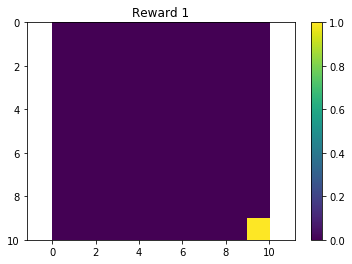

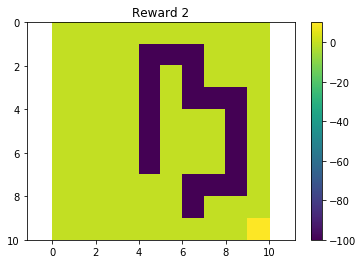

In [715]:
# QUESTION 1

reward_table_1 = np.zeros((10,10))
reward_table_1[9,9] = 1

reward_table_2 = np.zeros((10,10))
reward_table_2[1:7,4] = -100
reward_table_2[1,5] = -100
reward_table_2[1:4,6] = -100
reward_table_2[7:9,6] = -100
reward_table_2[3,7] = -100
reward_table_2[7,7] = -100
reward_table_2[3:8,8] = -100
reward_table_2[9,9] = 10

# Plot Rewards
plot_heat_map(reward_table_1,"Reward 1")
plot_heat_map(reward_table_2,"Reward 2")

In [716]:
# QUESTION 2: Value Iteration

def get_next_state(r, c, executed_action, state_shape):
    # Case where the resulting action is "up"
    if executed_action == 0:
        next_r, next_c = (max(r-1,0), c)
    # Case where the resulting action is "left"
    elif executed_action == 1:
        next_r, next_c = (r, max(c-1,0))
    # Case where the resulting action is "down"
    elif executed_action == 2:
        next_r, next_c = (min(r+1, state_shape[0]-1), c)
    # Case where the resulting action is "right"
    elif executed_action == 3:
        next_r, next_c = (r, min(c+1, state_shape[1]-1))
    return (next_r, next_c)

def get_trans_from_policy(policy, num_actions, w):
    transition_matrix = np.zeros((len(policy)*len(policy[0]), len(policy)*len(policy[0])))
    for r in range(policy.shape[0]):
        for c in range(policy.shape[1]):
            cur_state_index = r + c*policy.shape[0]
            opt_action = policy[r][c]
            for ex in range(num_actions):
                next_r, next_c = get_next_state(r,c,ex,policy.shape)
                trans_prob = w/4
                if ex == opt_action:
                    trans_prob +=  (1-w)
                next_state_index = next_r + next_c*policy.shape[0]
                transition_matrix[cur_state_index][next_state_index] += trans_prob
    return transition_matrix    

def policy_diff_matrix(P_a1, P_a2,gamma):
    return np.dot((P_a1-P_a2), np.linalg.inv(np.identity(P_a1.shape[0])-gamma*P_a1))

def get_LP_components(opt_policy, r_max, num_actions, gamma, random_action_prob):
    
    # Generate the optimal and sub-optimal transition matrices
    P_a1 = get_trans_from_policy(opt_policy, num_actions, random_action_prob)
    P_a2 = get_trans_from_policy(np.mod(opt_policy+1,num_actions), num_actions, random_action_prob)
    P_a3 = get_trans_from_policy(np.mod(opt_policy+2,num_actions), num_actions, random_action_prob)
    P_a4 = get_trans_from_policy(np.mod(opt_policy+3,num_actions), num_actions, random_action_prob)
    
    # Short-cuts for common matrices
    N = np.ma.size(opt_policy)
    I_NxN = np.identity(N)
    zero_NxN = np.zeros((N,N))
    
    # Generate D
    D_row_1 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a2, gamma)],axis=1)
    D_row_2 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a3, gamma)],axis=1)
    D_row_3 = np.concatenate([I_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a4, gamma)],axis=1)
    D_row_4 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a2, gamma)],axis=1)
    D_row_5 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a3, gamma)],axis=1)
    D_row_6 = np.concatenate([zero_NxN, zero_NxN, -policy_diff_matrix(P_a1, P_a4, gamma)],axis=1)
    D_row_7 = np.concatenate([zero_NxN, -I_NxN, I_NxN],axis=1)
    D_row_8 = np.concatenate([zero_NxN, -I_NxN, -I_NxN],axis=1)
    D_row_9 = np.concatenate([zero_NxN, zero_NxN, I_NxN],axis=1)
    D_row_10 = np.concatenate([zero_NxN, zero_NxN, -I_NxN],axis=1)
    D = np.concatenate([D_row_1,D_row_2,D_row_3,D_row_4,D_row_5,D_row_6,D_row_7,D_row_8,D_row_9,D_row_10],axis=0)
    
    # Generate b
    b = np.concatenate([np.zeros((8*N,)), r_max*np.ones((2*N,))])
    
    return D, b
    
def value_iteration(reward, estimation_step, w, gamma):
    # Initialization Step
    V = np.zeros(reward.shape)
    P = np.zeros(reward.shape)
    delta = float('inf')
    
    iteration = 0
    while delta > estimation_step:
        delta = 0
        # Value estimation step
        for r in range(V.shape[0]):
            for c in range(V.shape[1]):

                # Get the value for each action and store the max value
                best_action_value = -float('inf')
                
                # By default the best action is 'up'
                best_action = 0 
                
                for a in range(4):
                    action_value = 0
                    # For each actual executed action, get the state-action value
                    for ex in range(4):

                        next_r, next_c = get_next_state(r,c,ex,V.shape)

                        # Get the probability that s' is visited, given the s and a
                        execution_probability = (w / 4) # all of the neighboring states have a w/4 chance of being visited

                        # If the executed action is the same as the chosen action, this has a higher probability
                        if ex == a:
                            execution_probability += (1-w)

                        # Compute the value if the agent at state s picks action a, and ends up at [next_r, next_c]
                        action_value += (execution_probability) * (reward[next_r,next_c] + gamma*V[next_r,next_c])

                    # This is essentially maximizing the value with respect to each possible action
                    if action_value > best_action_value:
                        best_action_value = action_value
                        best_action = a

                delta = max(delta, abs(V[r][c] - best_action_value))
                V[r][c] = best_action_value 
                P[r][c] = best_action
            iteration += 1
    return V,P

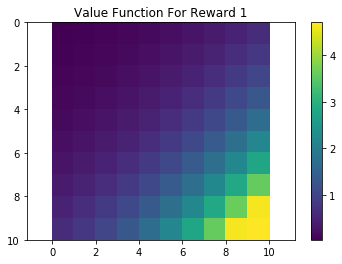

In [717]:
# Question 3: run value iteration and generate heat map on reward 1
estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
V,P = value_iteration(reward_table_1, estimation_step, random_action_prob, gamma)
plot_heat_map(V, "Value Function For Reward 1")

In [718]:
## Question 4: Explain the distribution

# The only reward is at the bottom right, so it makes sense that the value function is higher there.
# The value should decrease as you get away from the reward because we have a discount factor less than one.
# This means if the agent starts at the top left corner, it has a low value because it needs many steps to reach the reward.


In [719]:
# Question 5: Get the policy from the value

# Outputting the policy is already implemented in the value_iteration() method to prevent writing unnecessary code
# We will just implement the plotting of the policy with quivers

def plot_policy(P,title=""):
    U = np.zeros(P.shape)
    V = np.zeros(P.shape)
    for r in range(P.shape[0]):
        for c in range(P.shape[1]):
            # If policy says go up
            if P[r][c] == 0:
                U[r][c], V[r][c] = 0,1
            # If policy says go left
            elif P[r][c] == 1:
                U[r][c], V[r][c] = -1,0
            # If policy says go down
            elif P[r][c] == 2:
                U[r][c], V[r][c] = 0,-1
            # If policy says go right
            elif P[r][c] == 3:
                U[r][c], V[r][c] = 1,0
    plt.quiver(U,V,pivot='mid')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.title(title)
    plt.show()

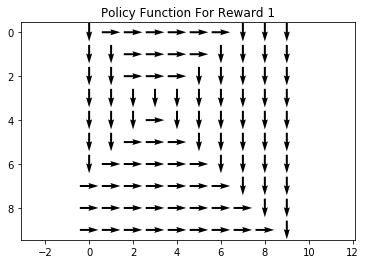

In [720]:
plot_policy(P,"Policy Function For Reward 1")

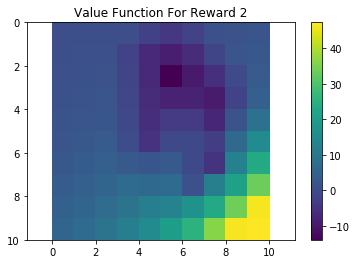

In [721]:
# Question 6, 7: Find the optimal values for Reward 2
estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
V_2,P_2 = value_iteration(reward_table_2, estimation_step, random_action_prob, gamma)
plot_heat_map(V_2, "Value Function For Reward 2")

In [722]:
# Question 8: Explain the distribution

# Close to the reward is still good, with low values near the dangerous territory with reward -100.

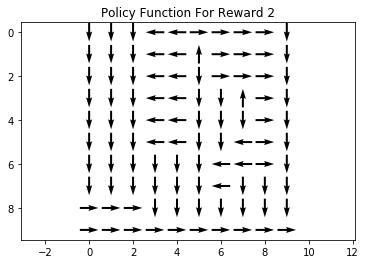

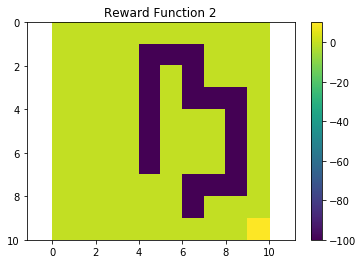

In [723]:
# Question 9: Plot the policy
plot_policy(P_2,"Policy Function For Reward 2")
plot_heat_map(reward_table_2, "Reward Function 2")

In [688]:
# 11

estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
V_1,P_1 = value_iteration(reward_table_1, estimation_step, random_action_prob, gamma)

N_lambda = 500
max_lambda = 5
accuracy_vector_1 = np.zeros(N_lambda)
rmax = 1

D, b = get_LP_components(P_1,rmax,4,gamma,random_action_prob)

t1 = time.time()
for i,L1 in enumerate(np.linspace(0,max_lambda,N_lambda)):
    if ((i+1) % 10) == 0:
        print("%d of %d complete in %f sec." %(i,N_lambda,time.time()-t1))
        t1 = time.time()
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
    opt_x = np.array(sol['x'])
    R = np.transpose(np.reshape(opt_x[200:],(10,10)))
    v,p = value_iteration(R, estimation_step, random_action_prob, gamma)
    accuracy = np.sum(P==p)/p.size
    accuracy_vector_1[i] = accuracy


9 of 500 complete in 2.904965 sec.
19 of 500 complete in 3.712333 sec.
29 of 500 complete in 3.423710 sec.
39 of 500 complete in 3.040910 sec.
49 of 500 complete in 3.204686 sec.
59 of 500 complete in 3.574429 sec.
69 of 500 complete in 3.478608 sec.
79 of 500 complete in 3.408376 sec.
89 of 500 complete in 3.418017 sec.
99 of 500 complete in 3.354779 sec.
109 of 500 complete in 3.192530 sec.
119 of 500 complete in 3.155586 sec.
129 of 500 complete in 3.317792 sec.
139 of 500 complete in 3.128518 sec.
149 of 500 complete in 3.168443 sec.
159 of 500 complete in 3.018584 sec.
169 of 500 complete in 3.218553 sec.
179 of 500 complete in 3.335871 sec.
189 of 500 complete in 3.141336 sec.
199 of 500 complete in 3.468663 sec.
209 of 500 complete in 3.585422 sec.
219 of 500 complete in 3.187909 sec.
229 of 500 complete in 3.237837 sec.
239 of 500 complete in 3.384254 sec.
249 of 500 complete in 3.355317 sec.
259 of 500 complete in 3.658590 sec.
269 of 500 complete in 3.613400 sec.
279 of 500 c

Text(0,0.5,'Accuracy of Derived Policy')

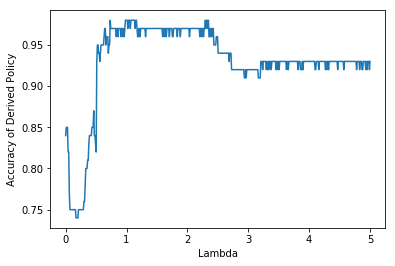

In [724]:
# 11
plt.plot(np.linspace(0,max_lambda,N_lambda),accuracy_vector_1)
plt.xlabel('Lambda')
plt.ylabel('Accuracy of Derived Policy')

Best Lambda: 2.344689
Best Accuracy: 0.980000
Accuracy: 0.980000


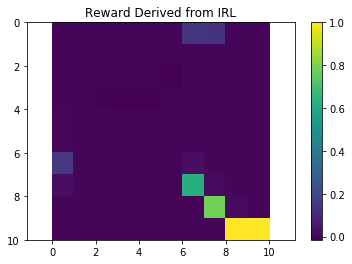

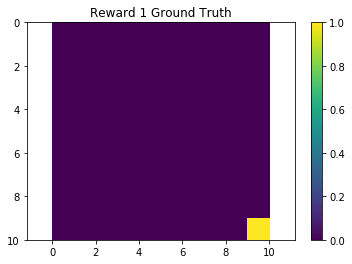

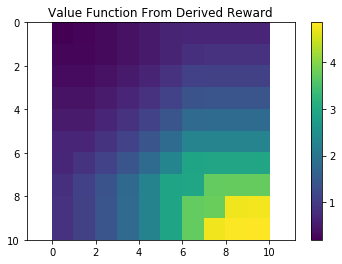

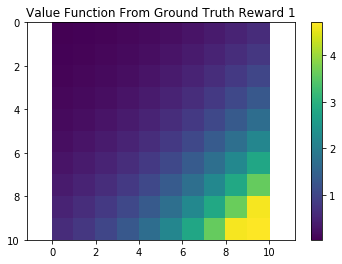

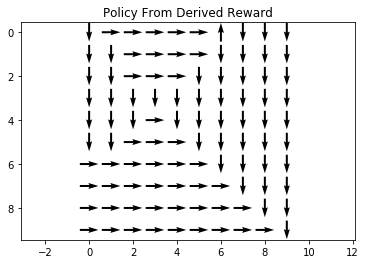

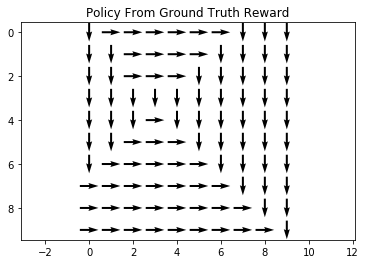

In [725]:
# 12, 13, 14, 15, 16, 17
estimation_step = 0.01
lambdas = np.linspace(0,max_lambda,N_lambda)
best_lambda = max(lambdas[accuracy_vector_1==np.max(accuracy_vector_1)])
print("Best Lambda: %f" % best_lambda)
print("Best Accuracy: %f" % max(accuracy_vector_1))
D, b = get_LP_components(P,1,4,gamma,random_action_prob)
c = np.concatenate([np.ones((N,)), -best_lambda*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
opt_x = np.array(sol['x'])
R = np.transpose(np.reshape(opt_x[200:],(10,10)))

v_best_lambda_1, p_best_lambda_1 = value_iteration(R, estimation_step, random_action_prob, gamma)
v_truth_1, p_truth_1 = value_iteration(reward_table_1, estimation_step, random_action_prob, gamma)
print("Accuracy: %f" % (np.sum(p_truth_1 == p_best_lambda_1)/p_truth_1.size))
plot_heat_map(R, "Reward Derived from IRL")
plot_heat_map(reward_table_1, "Reward 1 Ground Truth")
plot_heat_map(v_best_lambda_1, "Value Function From Derived Reward")
plot_heat_map(V, "Value Function From Ground Truth Reward 1")
plot_policy(p_best_lambda_1, "Policy From Derived Reward")
plot_policy(p_truth_1, "Policy From Ground Truth Reward")

In [682]:
#18 Sweep lambdas for IRL for reward 2

estimation_step = 0.01
random_action_prob = 0.1
gamma = 0.8
rmax = 100
V_2,P_2 = value_iteration(reward_table_2, estimation_step, random_action_prob, gamma)
D, b = get_LP_components(P_2,rmax,4,gamma,random_action_prob)

N_lambda = 500
max_lambda = 5
accuracy_vector_2 = np.zeros(N_lambda)

t1 = time.time()
for i,L1 in enumerate(np.linspace(0,max_lambda,N_lambda)):
    if ((i+1) % 10) == 0:
        print("%d of %d complete in %f sec." %(i,N_lambda,time.time()-t1))
        t1 = time.time()
    c = np.concatenate([np.ones((N,)), -L1*np.ones((N,)), np.zeros((N,))])
    sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
    opt_x = np.array(sol['x'])
    R = np.transpose(np.reshape(opt_x[200:],(10,10)))
    v,p = value_iteration(R, estimation_step, random_action_prob, gamma)
    accuracy = np.sum(P_2==p)/p.size
    accuracy_vector_2[i] = accuracy


9 of 500 complete in 4.111735 sec.
19 of 500 complete in 3.818908 sec.
29 of 500 complete in 4.014826 sec.
39 of 500 complete in 4.002314 sec.
49 of 500 complete in 4.199553 sec.
59 of 500 complete in 4.374092 sec.
69 of 500 complete in 3.940059 sec.
79 of 500 complete in 3.802038 sec.
89 of 500 complete in 4.720308 sec.
99 of 500 complete in 4.689985 sec.
109 of 500 complete in 3.822376 sec.
119 of 500 complete in 4.409007 sec.
129 of 500 complete in 4.563833 sec.
139 of 500 complete in 3.749551 sec.
149 of 500 complete in 3.976722 sec.
159 of 500 complete in 4.066388 sec.
169 of 500 complete in 4.124007 sec.
179 of 500 complete in 3.913591 sec.
189 of 500 complete in 3.888240 sec.
199 of 500 complete in 3.925745 sec.
209 of 500 complete in 3.826779 sec.
219 of 500 complete in 3.815606 sec.
229 of 500 complete in 3.721438 sec.
239 of 500 complete in 3.941152 sec.
249 of 500 complete in 2.145077 sec.
259 of 500 complete in 1.560289 sec.
269 of 500 complete in 1.431114 sec.
279 of 500 c

Text(0,0.5,'Accuracy of Derived Policy For Reward 2')

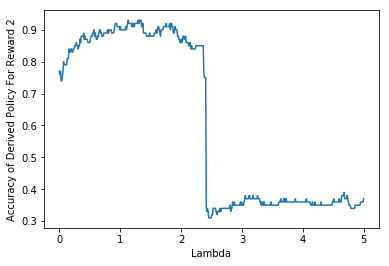

In [726]:
#18
plt.plot(np.linspace(0,max_lambda,N_lambda),accuracy_vector_2)
plt.xlabel('Lambda')
plt.ylabel('Accuracy of Derived Policy For Reward 2')

Best Lambda: 1.342685
Best Accuracy: 0.930000
Accuracy: 0.930000


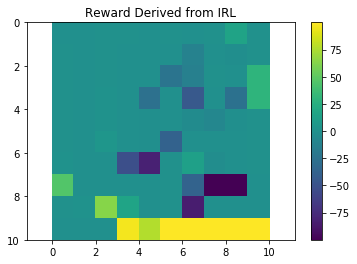

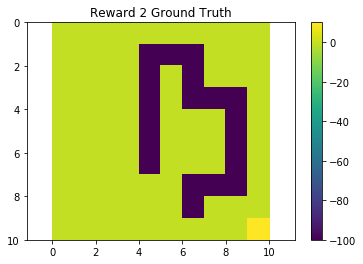

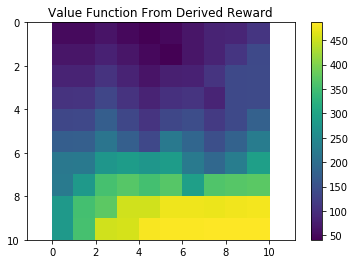

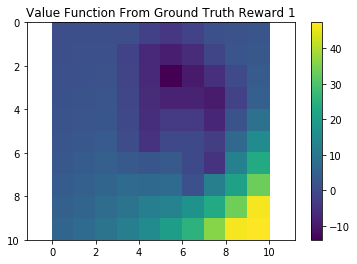

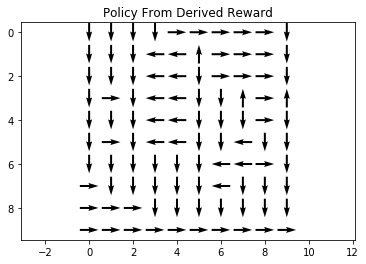

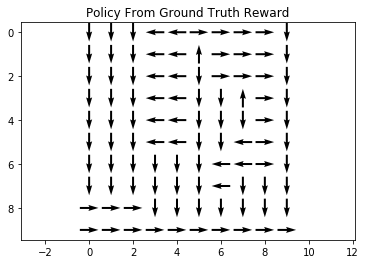

In [728]:
#19-24

estimation_step = 0.01
rmax = 100

lambdas = np.linspace(0,max_lambda,N_lambda)
best_lambda = max(lambdas[accuracy_vector_2==np.max(accuracy_vector_2)])
print("Best Lambda: %f" % best_lambda)
print("Best Accuracy: %f" % max(accuracy_vector_2))
D, b = get_LP_components(P_2,rmax,4,gamma,random_action_prob)
c = np.concatenate([np.ones((N,)), -best_lambda*np.ones((N,)), np.zeros((N,))])
sol = solvers.lp(matrix(-c),matrix(D),matrix(b))
opt_x = np.array(sol['x'])
R = np.transpose(np.reshape(opt_x[200:],(10,10)))

v_best_lambda_2, p_best_lambda_2 = value_iteration(R, estimation_step, random_action_prob, gamma)
v_truth_2, p_truth_2 = value_iteration(reward_table_2, estimation_step, random_action_prob, gamma)
accuracy_2 = np.sum(p_best_lambda_2==p_truth_2) / p_best_lambda_2.size
print("Accuracy: %f" % accuracy_2)

plot_heat_map(R, "Reward Derived from IRL")
plot_heat_map(reward_table_2, "Reward 2 Ground Truth")
plot_heat_map(v_best_lambda_2, "Value Function From Derived Reward")
plot_heat_map(v_truth_2, "Value Function From Ground Truth Reward 1")
plot_policy(p_best_lambda_2, "Policy From Derived Reward")
plot_policy(p_truth_2, "Policy From Ground Truth Reward")